In [1]:
%matplotlib inline
%run nbloader.py
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import numpy as np

BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205

ImportError: No module named root_numpy

In [2]:
from read_opera_bg import load_bg

importing Jupyter notebook from read_opera_bg.ipynb


In [3]:
from read_opera_mc import load_mc

importing Jupyter notebook from read_opera_mc.ipynb
('numtracks reduction by cuts: ', [18724, 18679, 15471, 12215, 6271, 6001])


In [4]:
# pbg = load_bg(step=1)

bg: 27322110 tracks


In [5]:
# pmc = load_mc(step=1)

('numtracks reduction by cuts: ', [18724, 18679, 15471, 12215, 6271, 6001])


In [7]:
import numpy as np
import pandas as pd

BT_Z_unique = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])
BRICK_X_MIN = 27762
BRICK_X_MAX = 72240
BRICK_Y_MIN = 3312
BRICK_Y_MAX = 76710
SAFE_M = 5000
dZ = 205

def shift_mc_data_with_margin(pmc, pbg, x_safe_margin = 0, y_safe_margin = 0):
    pmc_new = pmc.copy()
    mc_range = (pmc['ele_x'].max() - pmc['ele_x'].min(), pmc['ele_y'].max() - pmc['ele_y'].min())
    def coordinate_mover(x, min_mc_coord, aplitude, margin):
        return ((x - min_mc_coord) / aplitude - 0.5) * 2* (- margin - (left_bound - right_bound) / 2) +\
                (left_bound + right_bound) / 2
    
    right_bound = pbg['s.eX'].max()
    left_bound = pbg['s.eX'].min()
    
    pmc_new.ele_x = coordinate_mover(pmc.ele_x, pmc['ele_x'].min(), mc_range[0], x_safe_margin)
    pmc_new.BT_X = pmc['BT_X'] - (pmc['ele_x'] - pmc_new.ele_x)
    
    right_bound = pbg['s.eY'].max()
    left_bound = pbg['s.eY'].min()    
    
    pmc_new.ele_y = coordinate_mover(pmc.ele_y, pmc['ele_y'].min(), mc_range[1], y_safe_margin)
    pmc_new.BT_Y = pmc['BT_Y'] - (pmc['ele_y'] - pmc_new.ele_y)
    return pmc_new

def combine_mc_bg(pmc, pbg, events = [0], bg_frac=0.1):
    '''Create mixed DataFrame from selected MC Even_Id's and
       fraction of background'''
    #first of all generate background with random permutation by Z-axis
    pbg_frac = pbg.sample(frac=bg_frac)
    pbg_frac['s.eZ'] = np.random.choice(BT_Z_unique, size=len(pbg_frac))
    dmix = pd.DataFrame([
                pbg_frac['s.eX'],
                pbg_frac['s.eY'],
                pbg_frac['s.eZ'],
                pbg_frac['s.eTX'],
                pbg_frac['s.eTY'],
                pbg_frac['s.eChi2']],
                index=['X', 'Y', 'Z', 'TX', 'TY', 'chi2']).T
    dmix['plate_number'] = pbg_frac['s.eZ'].apply(lambda x:
                                                  np.where(BT_Z_unique == x)[0][0] + 1)
    dmix['signal'] = False
    dmix['event_id'] = -999
    
    dd = dmix
    print("Number of BG basetracks:", dmix.shape[0])
    #now we are generating signal uniformly in brick
    
    pmc_new = shift_mc_data_with_margin(pmc, pbg, 5000, 5000)
    pmc_new['chisquare'] = pmc_new.chisquare.apply(lambda x: x[x < 3]) 
    df = pmc_new[pmc_new.Event_id.isin(events)]
    print("Number of MC events:", df.shape[0])
    
    for _, row in df.iterrows():
        dmc = pd.DataFrame([        
                    row['BT_X'],
                    row['BT_Y'],
                    row['BT_Z'],
                    row['BT_SX'],
                    row['BT_SY'],
                    row['chisquare']],
                    index=['X', 'Y', 'Z', 'TX', 'TY', 'chi2']).T
        dmc['plate_number'] = row['BT_plate']
        dmc['signal'] = True
        dmc['event_id'] = row['Event_id']
        
        dd = pd.concat([dd, dmc], ignore_index=True)

    return dd

In [8]:
# ind = pmc.sample(frac=0.01).Event_id.values

In [10]:
#tested_data = combine_mc_bg(pmc, pbg, ind, bg_frac = 0.0005)

('Number of BG basetracks:', 13661)
('Number of MC basetracks:', 60)


In [14]:
def plot_bg_and_mc(pbg, pmc, id=0, step=1):
    df = pbg
    # mind the order!
    d0 = pd.DataFrame([
                df['Z'][::step],
                df['X'][::step],
                df['Y'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['TX'][::step]*dZ,
            df['TY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)

    df = pmc

    # mind the order!
    d0 = pd.DataFrame([
                df['Z'],
                df['X'],
                df['Y']],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['TX']*dZ,
            df['TY']*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    print(d1.shape)
    #print (d0)§
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.9, lw=2)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-0, elev=0)
    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)

(40710, 3)


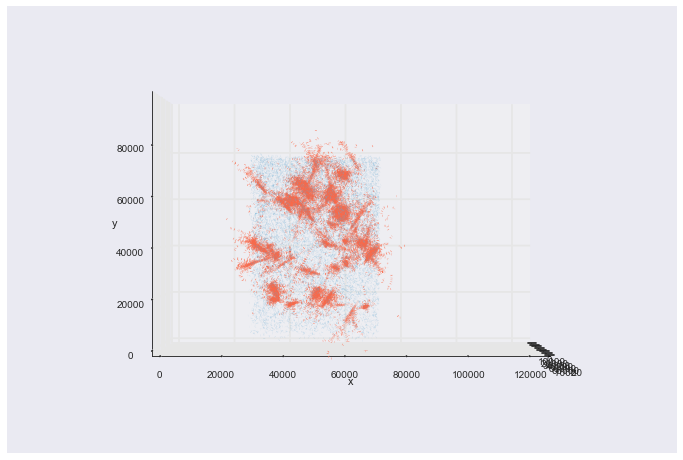

In [15]:
# plot_bg_and_mc(tested_data[tested_data.signal == False], tested_data[tested_data.signal == True])